# **Vegetable Image Classification for Ninjacart's Supply Chain Automation**

## **Problem Statement:**
### Assist Ninjacart in developing a precise image classifier to accurately distinguish between different types of vegetables such as onions, potatoes, and tomatoes. This model will leverage the dataset provided by Ninjacart, which includes images from both train and test sets. Successful identification will expedite the sorting process and reduce potential supply chain errors. An efficient image classifier will not only ensure the right businesses receive the intended produce but also enhance Ninjacart's commitment to leveraging cutting-edge technology for streamlined operations. The right classification also ensures any irrelevant images, like general market scenes, are appropriately flagged, leading to a more robust and reliable system.

In [52]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


***
***
## **1. Exploratory Data Analysis.**

In [3]:
train_data_dir = 'ninjacart_data/train'
test_data_dir = 'ninjacart_data/test'
target_size = (224, 224)
batch_size = 32

***
***
### **Distribution of images per class**

In [4]:
train_class_dirs = [os.path.join(train_data_dir, class_dir) for class_dir in os.listdir(train_data_dir)]
test_class_dirs = [os.path.join(test_data_dir, class_dir) for class_dir in os.listdir(test_data_dir)]

train_class_counts = {os.path.basename(class_dir): len(os.listdir(class_dir)) for class_dir in train_class_dirs}
test_class_counts = {os.path.basename(class_dir): len(os.listdir(class_dir)) for class_dir in test_class_dirs}

counts = pd.DataFrame({'train': train_class_counts, 'test': test_class_counts})

In [5]:
counts

train  test
indian market    599    81
onion            849    83
potato           898    81
tomato           789   106

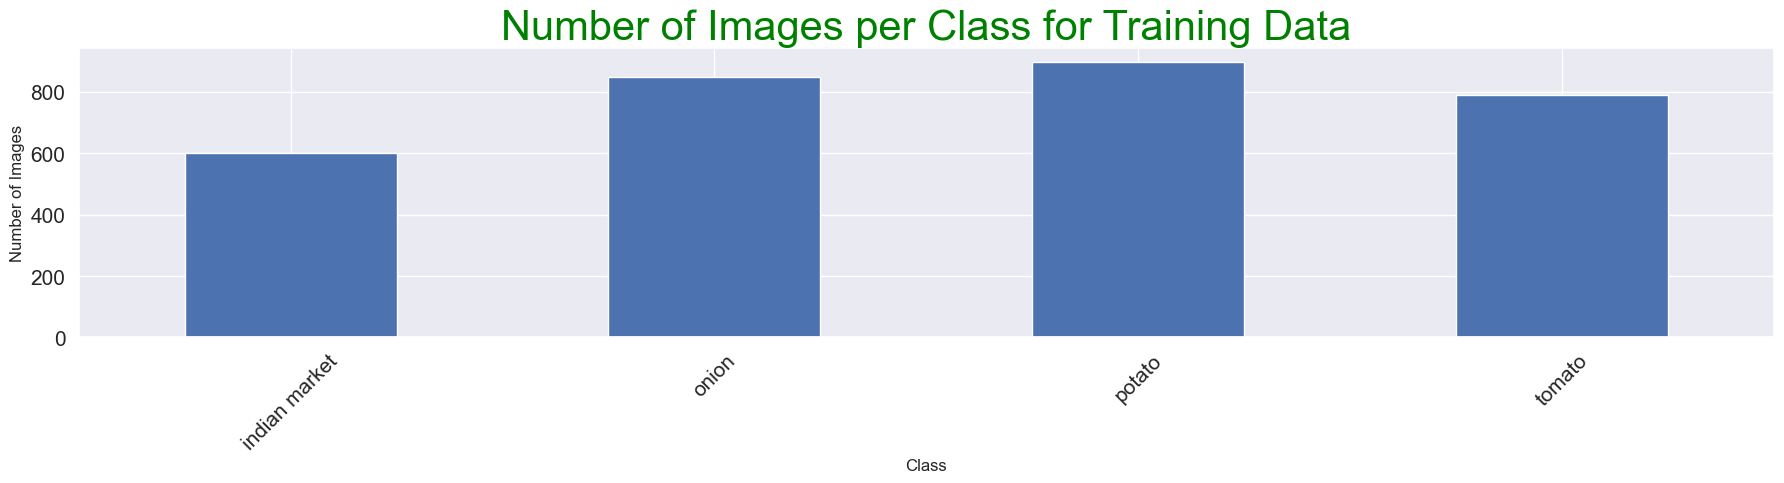

In [6]:
counts['train'].plot(kind='bar', figsize=(18,5), fontsize=15)
plt.title('Number of Images per Class for Training Data', fontsize=30, color="green")
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout();

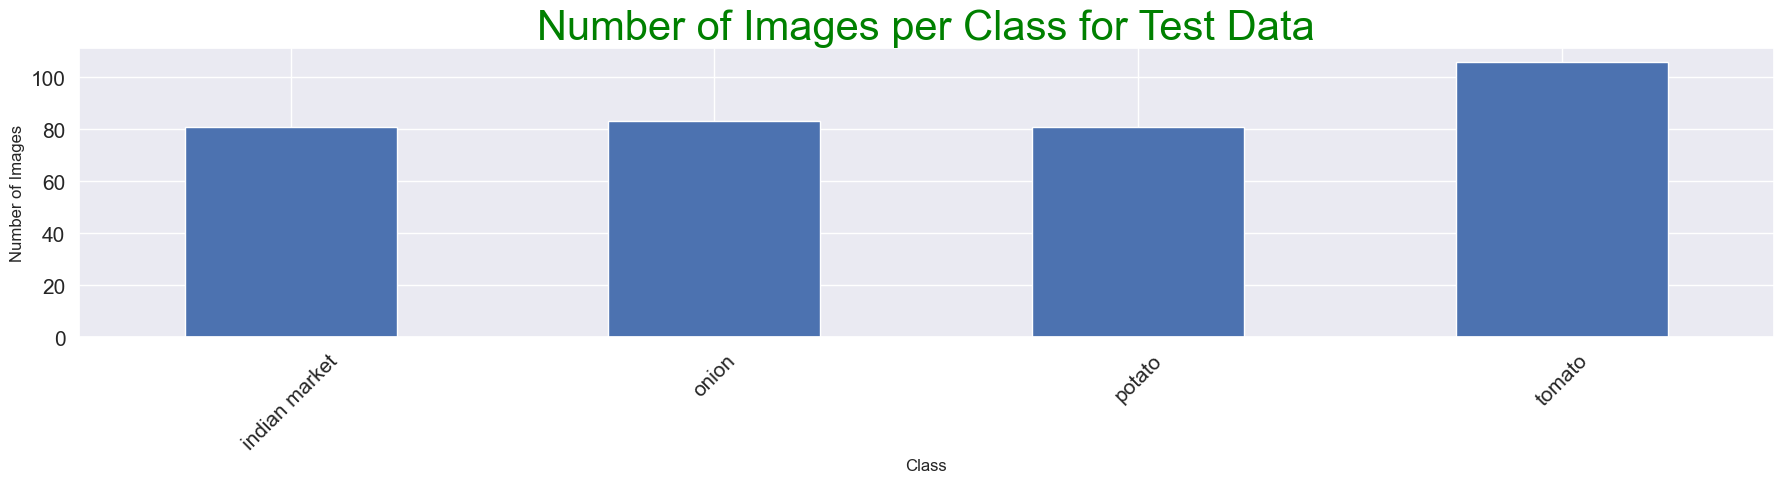

In [7]:
counts['test'].plot(kind='bar', figsize=(18,5), fontsize=15)
plt.title('Number of Images per Class for Test Data', fontsize=30, color="green")
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout();

***
***
### **Distribution of raw image dimensions**

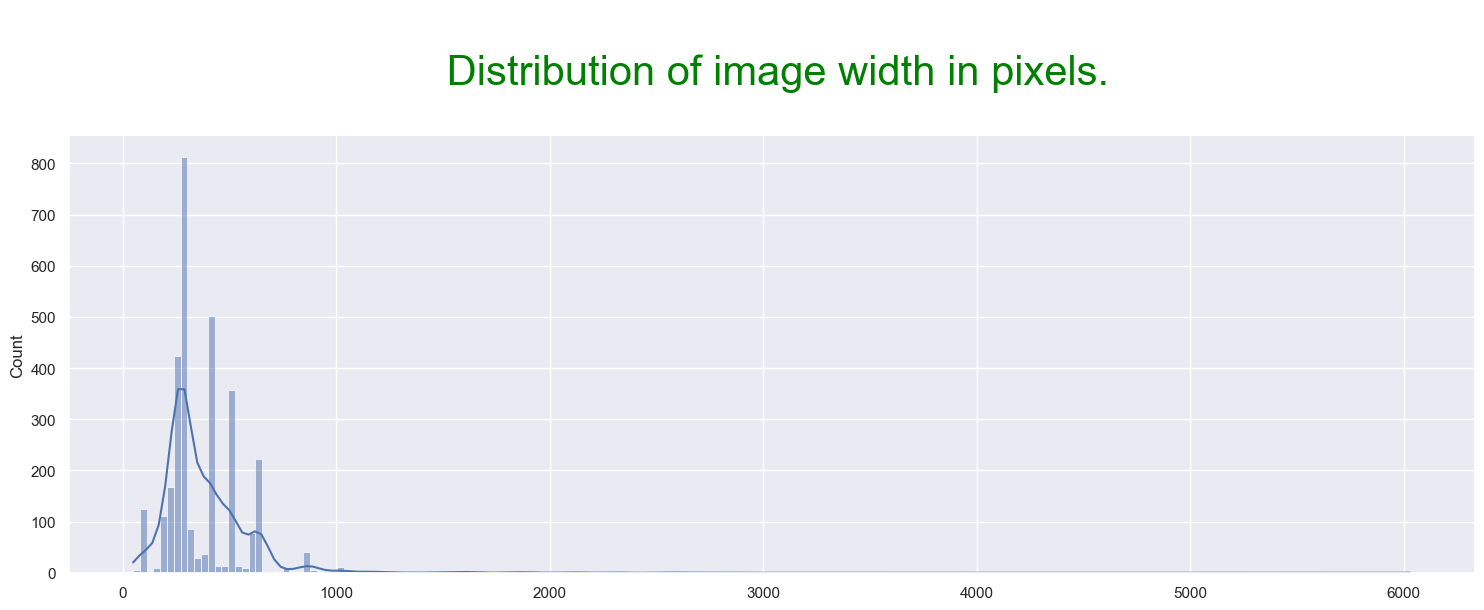

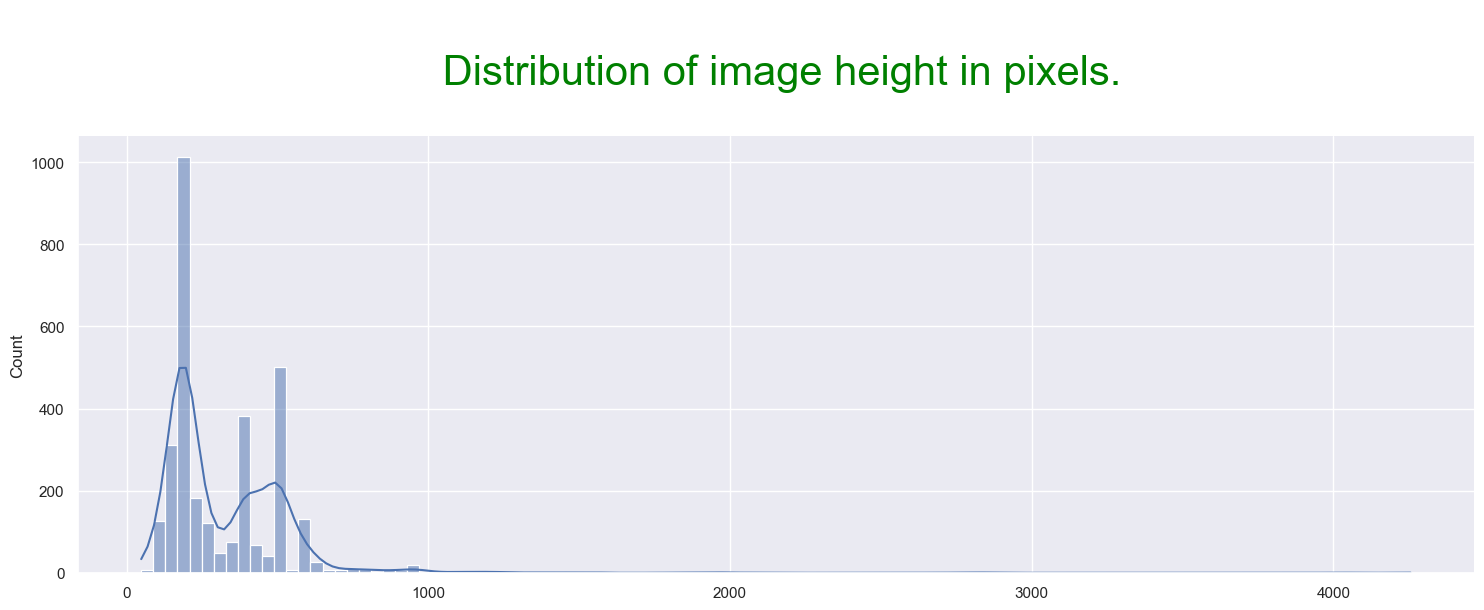

In [8]:
image_dimensions = []
for class_dir in train_class_dirs:
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
            image_dimensions.append((width, height))
widths, heights = zip(*image_dimensions)
sns.displot(widths, kde=True, height=5, aspect=3)
plt.title(f"\n Distribution of image width in pixels.\n", fontsize=30, color="green")
plt.show()
sns.displot(heights, kde=True, height=5, aspect=3)
plt.title(f"\n Distribution of image height in pixels.\n", fontsize=30, color="green")
plt.show()

***
***
### **Different images in a batch**

Found 3135 images belonging to 4 classes.


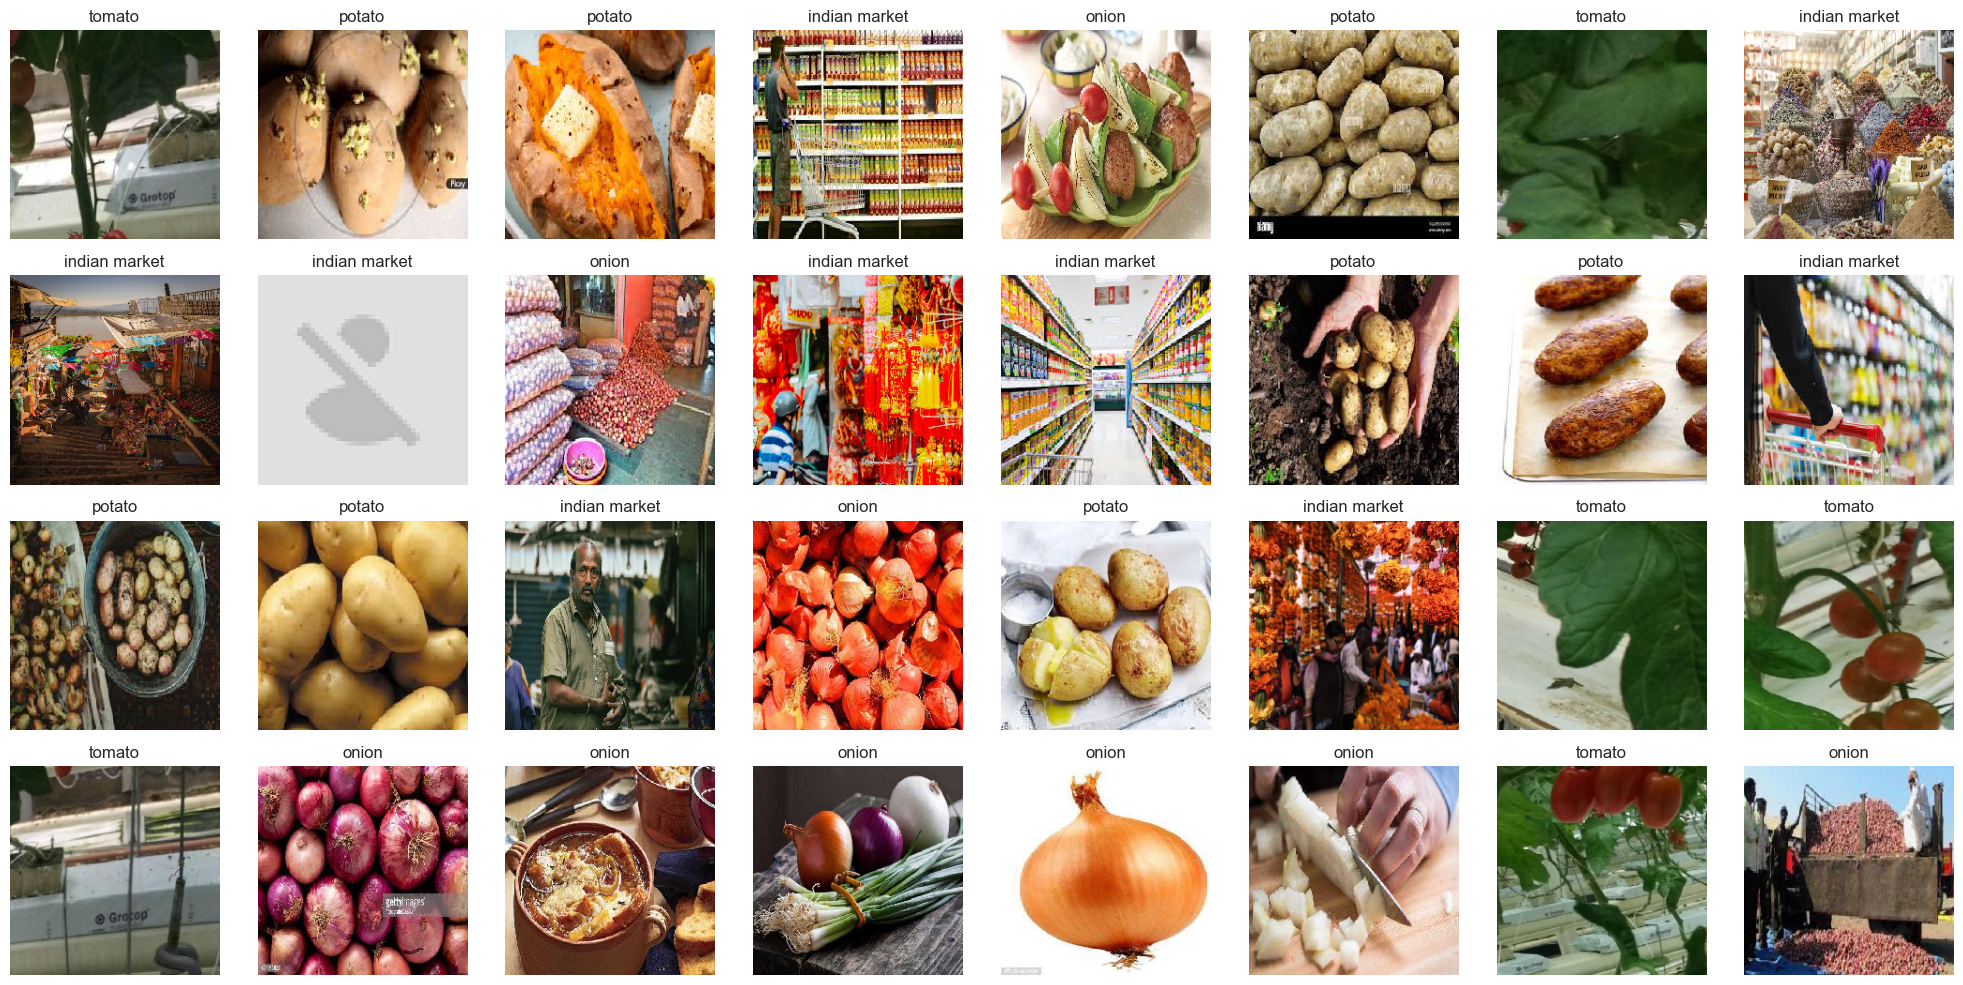

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
image_iterator = datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)
batch_images, batch_labels = next(image_iterator)
class_labels = list(image_iterator.class_indices.keys())
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for img, label, ax in zip(batch_images, batch_labels, axes.ravel()):
    ax.imshow(img)
    ax.set_title(class_labels[label.argmax()])
    ax.axis('off')
plt.tight_layout()
plt.show()

***
***
## **2. Baseline CNN Model from scratch.**

***
***
### **Train-Val-Test split**

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


***
***
### **Model Architecture**

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(224, 224, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0

***
***
### **Model Training**

In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model1.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_cb])

Epoch 1/100
78/78 [==============================] - 19s 242ms/step - loss: 14.3919 - accuracy: 0.6704 - val_loss: 4.9849 - val_accuracy: 0.4095
Epoch 2/100
78/78 [==============================] - 19s 246ms/step - loss: 1.5995 - accuracy: 0.7426 - val_loss: 2.6519 - val_accuracy: 0.4688
Epoch 3/100
78/78 [==============================] - 16s 202ms/step - loss: 0.4481 - accuracy: 0.8516 - val_loss: 4.6720 - val_accuracy: 0.4589
Epoch 4/100
78/78 [==============================] - 19s 239ms/step - loss: 0.3869 - accuracy: 0.8702 - val_loss: 1.9520 - val_accuracy: 0.5461
Epoch 5/100
78/78 [==============================] - 16s 199ms/step - loss: 0.3380 - accuracy: 0.8858 - val_loss: 3.2898 - val_accuracy: 0.5066
Epoch 6/100
78/78 [==============================] - 18s 231ms/step - loss: 0.3792 - accuracy: 0.8685 - val_loss: 1.2909 - val_accuracy: 0.6875
Epoch 7/100
78/78 [==============================] - 18s 233ms/step - loss: 0.3704 - accuracy: 0.8810 - val_loss: 0.6986 - val_accuracy

***
***
### **Metrics**

***
***
#### 1. From the model accuracy plot, we can deduce that the model is overfitting and not able to generalize very well. Need to add Dropouts.

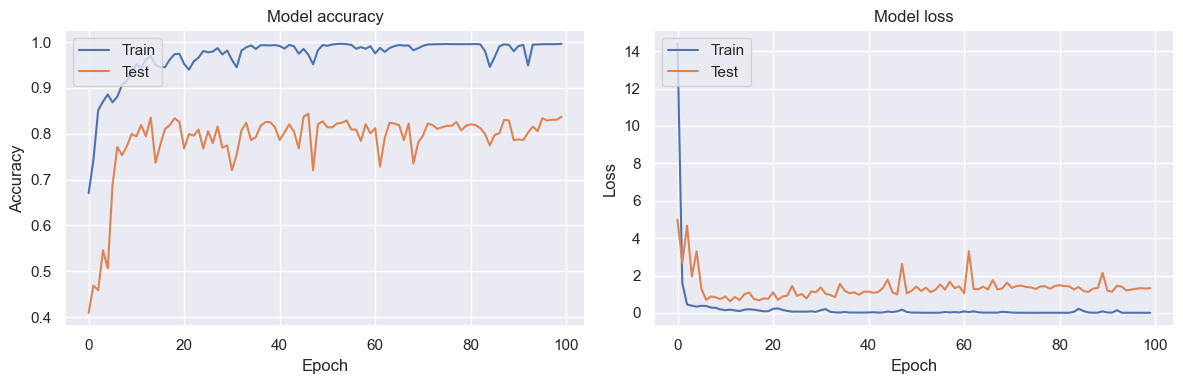

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
model1 = tf.keras.models.load_model("model1.h5")

***
***
#### 2. Accuracy on test data is roughly 79%.

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

10/10 [==============================] - 2s 155ms/step - loss: 1.5361 - accuracy: 0.7969
Test accuracy: 79.69%


***
***
#### 3. From the confusion matrix, we can deduce that many Indian market and potato pictures are wrongly classified as onions. Many onions are also wrongly classified as potato. that means the model is confused between the images of onions and potatoes a lot.

Found 351 images belonging to 4 classes.


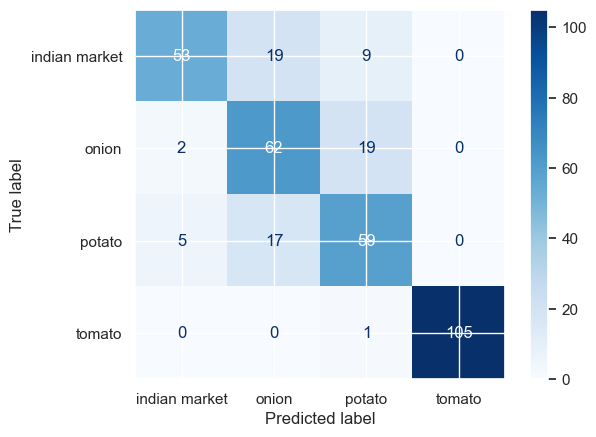

In [36]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
predictions = model1.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
num_of_pred = len(predicted_classes)
true_classes = true_classes[:num_of_pred]
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

***
***
## **3. Baseline CNN Model with Dropouts.**

***
***
### **Train-Val-Test split**

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


***
***
### **Model Architecture**

In [24]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3,3), input_shape=(224, 224, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(4, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 64)     

***
***
### **Model Training**

In [26]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model2.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_cb]
)

Epoch 1/100
78/78 [==============================] - 19s 245ms/step - loss: 0.5769 - accuracy: 0.7648 - val_loss: 0.8022 - val_accuracy: 0.7155
Epoch 2/100
78/78 [==============================] - 17s 214ms/step - loss: 0.5858 - accuracy: 0.7862 - val_loss: 0.8184 - val_accuracy: 0.7072
Epoch 3/100
78/78 [==============================] - 17s 217ms/step - loss: 0.5969 - accuracy: 0.7733 - val_loss: 0.8920 - val_accuracy: 0.6859
Epoch 4/100
78/78 [==============================] - 20s 252ms/step - loss: 0.5062 - accuracy: 0.8003 - val_loss: 0.7719 - val_accuracy: 0.7484
Epoch 5/100
78/78 [==============================] - 17s 213ms/step - loss: 0.4983 - accuracy: 0.8052 - val_loss: 0.9794 - val_accuracy: 0.6480
Epoch 6/100
78/78 [==============================] - 20s 252ms/step - loss: 0.4970 - accuracy: 0.8140 - val_loss: 0.6624 - val_accuracy: 0.7615
Epoch 7/100
78/78 [==============================] - 16s 211ms/step - loss: 0.5984 - accuracy: 0.7277 - val_loss: 0.7458 - val_accuracy:

***
***
### **Metrics**

***
***
#### 1. From the model accuracy plot, we can deduce that the model is still overfitting and not able to generalize very well. Need to reduce Dropouts and add Augmentation.

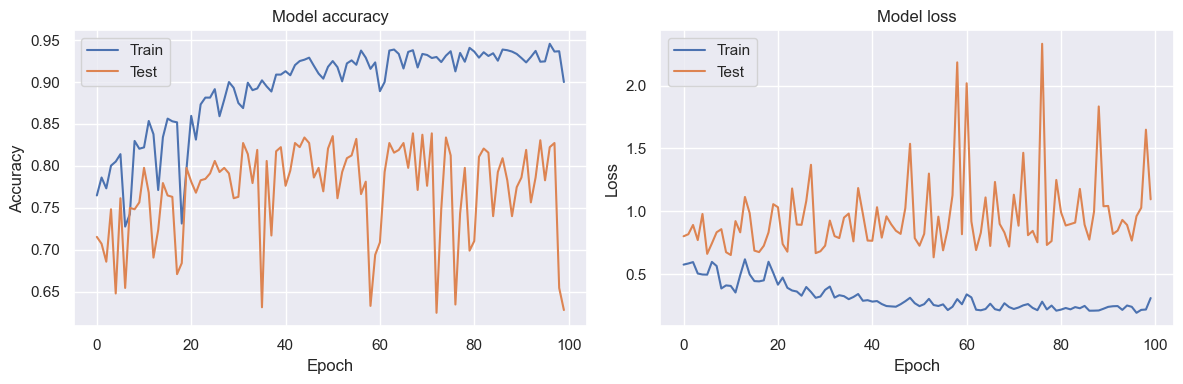

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
model2 = tf.keras.models.load_model("model2.h5")

***
***
#### 2. Accuracy on test data is roughly 73%.

In [29]:
test_loss, test_accuracy = model2.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

10/10 [==============================] - 5s 543ms/step - loss: 0.7185 - accuracy: 0.7375
Test accuracy: 73.75%


***
***
#### 3. From the confusion matrix, we can deduce that the model has become worse after adding only 10% Droputs.

Found 351 images belonging to 4 classes.


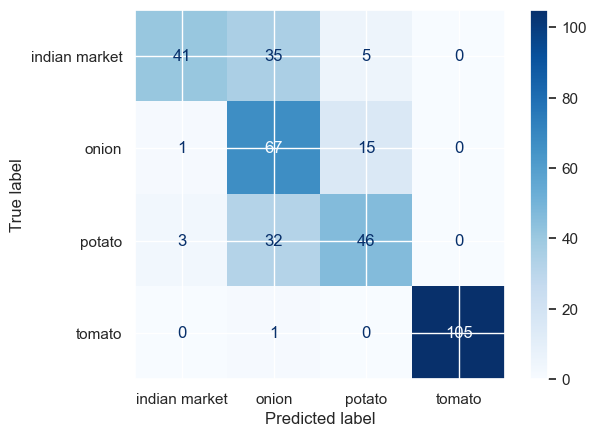

In [33]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
predictions = model2.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
num_of_pred = len(predicted_classes)
true_classes = true_classes[:num_of_pred]
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

***
***
## **4. Baseline CNN Model with Dropouts and Data Augmentation.**

***
***
### **Train-Val-Test split**

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


***
***
### **Model Architecture**

In [32]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3,3), input_shape=(224, 224, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.05))

model3.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.05))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.05))
model3.add(Dense(4, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 64)     

***
***
### **Model Training**

In [33]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model3.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_cb]
)

Epoch 1/100
78/78 [==============================] - 46s 593ms/step - loss: 24.1373 - accuracy: 0.5998 - val_loss: 1.2003 - val_accuracy: 0.4934
Epoch 2/100
78/78 [==============================] - 43s 557ms/step - loss: 0.9199 - accuracy: 0.6551 - val_loss: 2.0482 - val_accuracy: 0.3388
Epoch 3/100
78/78 [==============================] - 42s 544ms/step - loss: 0.8080 - accuracy: 0.7350 - val_loss: 1.9400 - val_accuracy: 0.3964
Epoch 4/100
78/78 [==============================] - 43s 550ms/step - loss: 0.7371 - accuracy: 0.7132 - val_loss: 1.2999 - val_accuracy: 0.5559
Epoch 5/100
78/78 [==============================] - 43s 546ms/step - loss: 0.6475 - accuracy: 0.7745 - val_loss: 1.9279 - val_accuracy: 0.5411
Epoch 6/100
78/78 [==============================] - 43s 548ms/step - loss: 0.6301 - accuracy: 0.7527 - val_loss: 1.2159 - val_accuracy: 0.5510
Epoch 7/100
78/78 [==============================] - 46s 591ms/step - loss: 0.6067 - accuracy: 0.7693 - val_loss: 0.8047 - val_accuracy

***
***
### **Metrics**

***
***
#### 1. From the model accuracy plot, we can deduce that the model variance is slightly reduced now with higher validation accuracies.

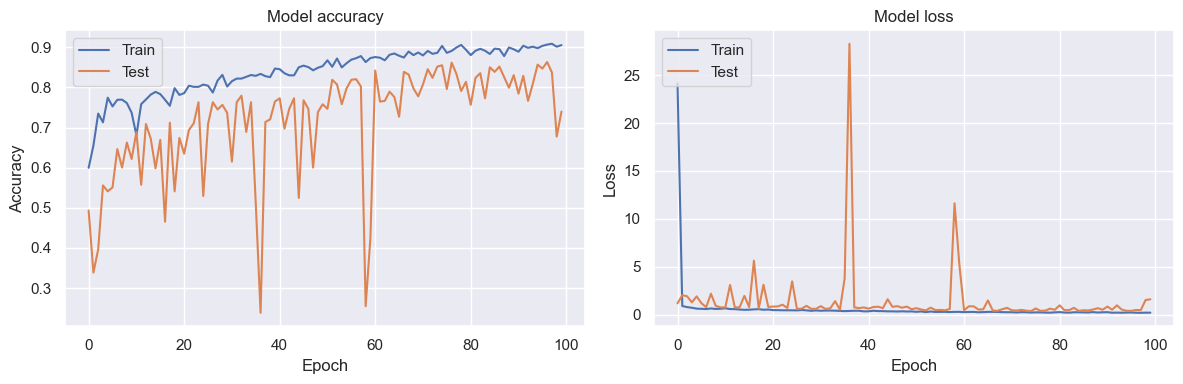

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
model3 = tf.keras.models.load_model("model3.h5")

***
***
#### 2. Accuracy on test data is roughly 83%, which is significant improvement of around 10% compared to previous model.

In [36]:
test_loss, test_accuracy = model3.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

10/10 [==============================] - 1s 149ms/step - loss: 0.4407 - accuracy: 0.8375
Test accuracy: 83.75%


***
***
#### 3. From the confusion matrix, we can deduce that the model is still getting confused between onions and potatoes.

Found 351 images belonging to 4 classes.


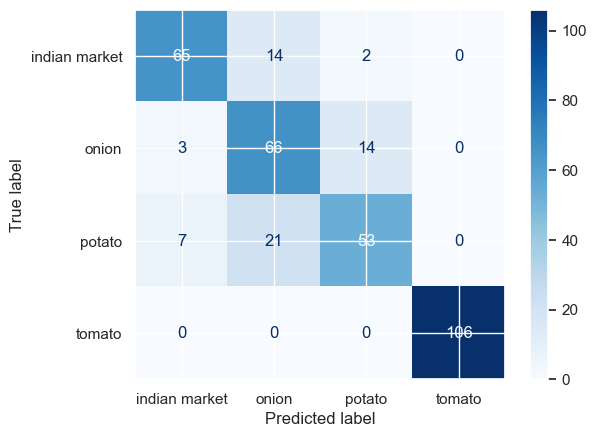

In [30]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
predictions = model3.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
num_of_pred = len(predicted_classes)
true_classes = true_classes[:num_of_pred]
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

***
***
## **5. Transfer Learning with VGG-16.**

***
***
### **Train-Val-Test split**

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


***
***
### **Fusing feature extractor layers of VGG-16 with 4 way classifier layers**

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [14]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

***
***
### **Freezing feature extractor layers of VGG-16**

In [53]:
for layer in base_model.layers:
    layer.trainable = False

***
***
### **Model Architecture**

In [54]:
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

***
***
### **Model Training**

In [16]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("vgg16.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
historyvgg = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_cb]
)

Epoch 1/30
78/78 [==============================] - 52s 671ms/step - loss: 1.2964 - accuracy: 0.7265 - val_loss: 0.3628 - val_accuracy: 0.8487
Epoch 2/30
78/78 [==============================] - 55s 707ms/step - loss: 0.3212 - accuracy: 0.8741 - val_loss: 0.3069 - val_accuracy: 0.8602
Epoch 3/30
78/78 [==============================] - 55s 699ms/step - loss: 0.2925 - accuracy: 0.8846 - val_loss: 0.2675 - val_accuracy: 0.8914
Epoch 4/30
78/78 [==============================] - 51s 652ms/step - loss: 0.2557 - accuracy: 0.8967 - val_loss: 0.3101 - val_accuracy: 0.8503
Epoch 5/30
78/78 [==============================] - 50s 642ms/step - loss: 0.2329 - accuracy: 0.9092 - val_loss: 0.3029 - val_accuracy: 0.8931
Epoch 6/30
78/78 [==============================] - 54s 687ms/step - loss: 0.2247 - accuracy: 0.9096 - val_loss: 0.2585 - val_accuracy: 0.8997
Epoch 7/30
78/78 [==============================] - 56s 712ms/step - loss: 0.2188 - accuracy: 0.9181 - val_loss: 0.2215 - val_accuracy: 0.9079

***
***
### **Metrics**

***
***
#### 1. From the model accuracy plot, we can deduce that the model variance has reduced significantly.

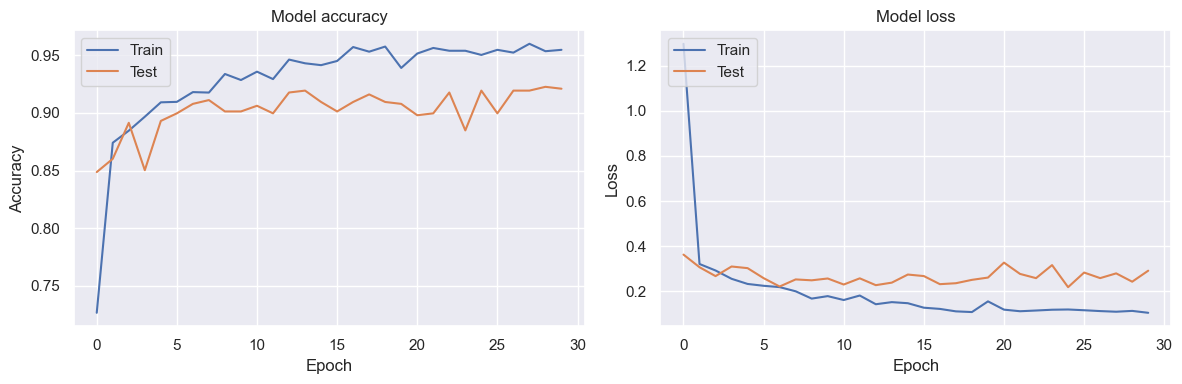

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyvgg.history['accuracy'])
plt.plot(historyvgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(historyvgg.history['loss'])
plt.plot(historyvgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
vgg16_model = tf.keras.models.load_model("vgg16.h5")

***
***
#### 2. Accuracy on test data is roughly 86%, which is improvement of around 3% compared to the previous best model.

In [21]:
test_loss, test_accuracy = vgg16_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

10/10 [==============================] - 3s 253ms/step - loss: 0.4304 - accuracy: 0.8656
Test accuracy: 86.56%


***
***
#### 3. From the confusion matrix, we can deduce that the confusion between onions and potatoes is slightly reduced, but not significantly.

Found 351 images belonging to 4 classes.


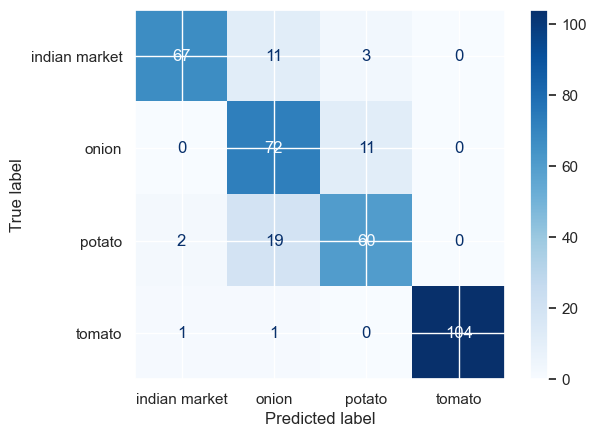

In [27]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
predictions = vgg16_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
num_of_pred = len(predicted_classes)
true_classes = true_classes[:num_of_pred]
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

***
***
## **6. Transfer Learning with MobileNet.**

***
***
### **Train-Val-Test split**

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


***
***
### **Fusing feature extractor layers of MobileNet with 4 way classifier layers**

In [44]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [45]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
mobile_model = Model(inputs=base_model.input, outputs=predictions)

***
***
### **Freezing feature extractor layers of MobileNet**

In [55]:
for layer in base_model.layers:
    layer.trainable = False

***
***
### **Model Architecture**

In [56]:
mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobile_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

***
***
### **Model Training**

In [47]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mobilenet.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
historymobile = mobile_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_cb]
)

Epoch 1/30
78/78 [==============================] - 44s 561ms/step - loss: 0.3530 - accuracy: 0.8686 - val_loss: 0.1223 - val_accuracy: 0.9474
Epoch 2/30
78/78 [==============================] - 46s 591ms/step - loss: 0.1287 - accuracy: 0.9520 - val_loss: 0.0989 - val_accuracy: 0.9605
Epoch 3/30
78/78 [==============================] - 43s 551ms/step - loss: 0.0985 - accuracy: 0.9609 - val_loss: 0.1101 - val_accuracy: 0.9704
Epoch 4/30
78/78 [==============================] - 43s 547ms/step - loss: 0.1155 - accuracy: 0.9585 - val_loss: 0.2182 - val_accuracy: 0.9211
Epoch 5/30
78/78 [==============================] - 43s 550ms/step - loss: 0.0898 - accuracy: 0.9673 - val_loss: 0.0942 - val_accuracy: 0.9638
Epoch 6/30
78/78 [==============================] - 42s 538ms/step - loss: 0.0804 - accuracy: 0.9718 - val_loss: 0.1574 - val_accuracy: 0.9441
Epoch 7/30
78/78 [==============================] - 42s 541ms/step - loss: 0.0547 - accuracy: 0.9794 - val_loss: 0.1616 - val_accuracy: 0.9457

***
***
### **Metrics**

***
***
#### 1. From the model accuracy plot, we can deduce that by far, this is the best model we have trained till now.

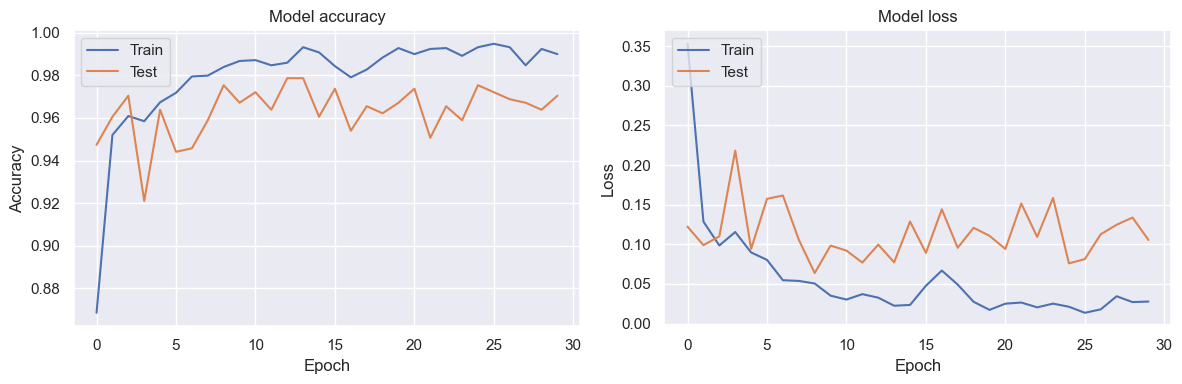

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historymobile.history['accuracy'])
plt.plot(historymobile.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(historymobile.history['loss'])
plt.plot(historymobile.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [49]:
mobile_model = tf.keras.models.load_model("mobilenet.h5")

***
***
#### 2. Accuracy on test data is roughly 92%, which is improvement of around 6% compared to the previous best model.

In [50]:
test_loss, test_accuracy = mobile_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

10/10 [==============================] - 2s 156ms/step - loss: 0.2294 - accuracy: 0.9281
Test accuracy: 92.81%


***
***
#### 3. From the confusion matrix, we can deduce that although the potatoes are still getting classified as onions. But now onions are no more getting confused as potatoes. Some Indian market pictures are getting classified as onions, maybe because of the presence of actual onions in them.

Found 351 images belonging to 4 classes.


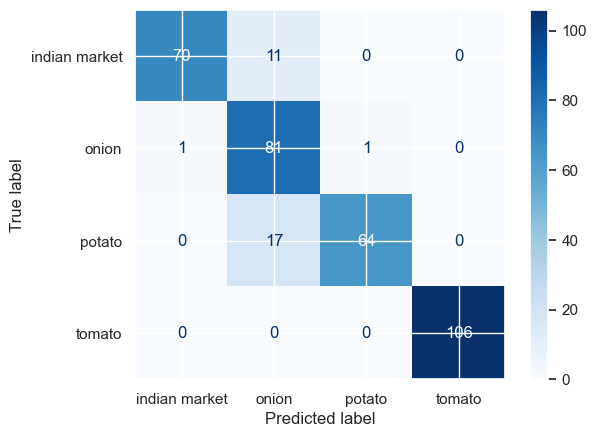

In [69]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
predictions = mobile_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
num_of_pred = len(predicted_classes)
true_classes = true_classes[:num_of_pred]
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

***
***
## **7. Summary and Insights.**
#### **A.** Model trained with MobileNet gave by far the highest accuracy.
#### **B.** Since the model only used 526k parameters, it can be transported or deployed efficiently.
#### **C.** Since the images were of different sizes, we had to resize them to 224x224.
#### **D.** Augmentation significantly improved performance for the CNN model built from scratch.
#### **E.** Some Indian market images contain vegetables too, which have caused models to confuse.